In [1]:
# Render our plots inline
%matplotlib inline

from requests import get
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from pandas.io.json import json_normalize

# Basic Settings
Here you need to specify where the API is running. The default port is 8080, so if you only change the machine, specify it's name in "server"

In [2]:
server = 'localhost'
#server = 'hv-6066.idi.ntnu.no'

port = '8080'
url = 'http://' + server + ':' + port + '/'

# Case Representation

These methods show how to fetch an existing case representation from the APO 
Get the model contents: concept, attribute, attribute types

In [3]:
def get_concepts():
    raw = pd.DataFrame(requests.get(url + 'concepts/').json()) 
    concepts = pd.DataFrame.from_records(raw).values.tolist()
    return concepts

def get_globalsim(concept):
    raw = pd.DataFrame(requests.get(url + 'concepts/' + concept + '/amalgamationFunctions').json()) 
    global_sim = pd.DataFrame.from_records(raw).values.tolist()
    return global_sim

def get_attributes(concept):
    raw = pd.DataFrame(requests.get(url + 'concepts/' + concept + '/attributes').json()) 
    attributes = pd.DataFrame(raw).reset_index()
    attributes.columns = ['name', 'type']
    return attributes

def get_attribute_value_range(concept, attribute):
    raw = pd.DataFrame(requests.get(url + 'values?attribute%20name=' + attribute + '&concept%20name=' + concept).json()) 
    value_range = pd.Series.tolist(pd.DataFrame(raw).iloc[0])
    return value_range

# Case Base
Get the model contents: concept, casebase, attribute, attribute types

In [4]:
def get_casebases():
    raw = pd.DataFrame(requests.get(url + 'casebase/').json()) 
    casebases = pd.DataFrame.from_records(raw).values.tolist()
    return casebases

def get_instances(concept, casebase):
    raw = pd.DataFrame(requests.get(url + 'concepts/' + concept + '/casebases/' + casebase + '/instances').json()) 
    instances = raw.apply(pd.to_numeric, errors='coerce').fillna(raw)
    return instances

# Convenience Functions
- Create plots for case base content

In [5]:
def plot_numeric(data, attribute):
    ax = sns.distplot(data[attribute].astype(int), rug=True, hist=True, kde=False)
    ax.set(xlabel=attribute, ylabel='Count', title=attribute + ' (mean: '+data[attribute].astype(int).mean().__str__()+')')

def plot_symbolic(data, attribute):
    ax = sns.countplot(x=attribute, data=data, order = data[attribute].value_counts().index)
    ax.set(xlabel=attribute, ylabel='Dist', title=attribute)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Examples

The following cells will show how the fetch the content and configuration of the CBR via the Rest API.


In [6]:
get_concepts() # returns the list of concepts existing in the CBR system

[['patient']]

In [7]:
get_attributes(get_concepts()[0][0]) # returns a dataframe of attribute names and their type existing in the CBR system

,name,type
0,age,IntegerDesc
1,blood_pressure,IntegerDesc
2,bmi,FloatDesc
3,diabetes_pedigree_function,FloatDesc
4,glucose,IntegerDesc
5,id,IntegerDesc
6,insulin,IntegerDesc
7,outcome,IntegerDesc
8,pregnancies,IntegerDesc
9,skin_thickness,IntegerDesc


In [8]:
get_globalsim(get_concepts()[0][0]) # returns a list of names of existing global similarity functions

[['eq_wt_all'],
 ['sample_sim'],
 ['rank_wt_75'],
 ['rank_wt_all'],
 ['manual_wt_all'],
 ['manual_wt_75'],
 ['manual_wt_50'],
 ['rank_wt_50'],
 ['score_wt_50'],
 ['score_wt_all'],
 ['score_wt_75'],
 ['eq_wt_75'],
 ['eq_wt_50']]

In [9]:
get_attribute_value_range('patient', 'outcome')  # returns the value range for an attribute (min/max for numbers; entire list for symbols)

[[0, 1]]

In [10]:
get_casebases() # returns the list of existing case bases

[['case_base']]

In [11]:
concept = 'patient'
casebase = 'case_base'
attr = 'age'
simFct = 'sample_sim'

In [12]:
get_instances(concept, casebase).head() # returns the contents of the case base

,age,blood_pressure,bmi,caseID,diabetes_pedigree_function,glucose,id,insulin,outcome,pregnancies,similarity,skin_thickness
0,25,82,38.4,patient370,2.137,173,371,465,1,3,1,48
1,42,90,33.5,patient491,0.292,89,492,0,0,2,1,30
2,24,65,36.8,patient490,0.629,83,491,66,0,2,1,28
3,30,64,34.5,patient132,0.356,170,133,225,1,3,1,37
4,25,68,35.8,patient253,0.238,86,254,0,0,0,1,32


In [13]:
dataset = get_instances(concept, casebase)
dataset.shape

(768, 12)

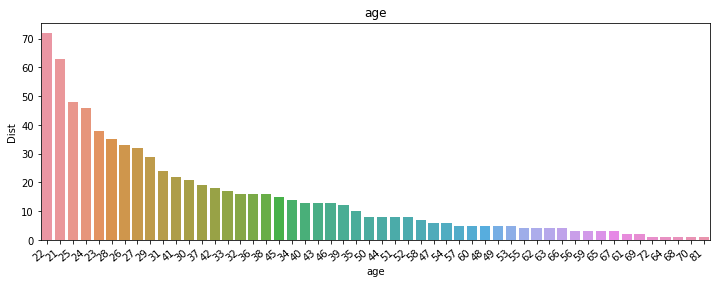

In [14]:
plt.rcParams["figure.figsize"] = (12, 4)
plot_symbolic(get_instances(concept, casebase), attr)

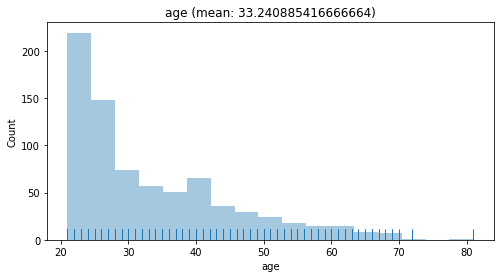

In [15]:
plt.rcParams["figure.figsize"] = (8, 4)
plot_numeric(get_instances(concept, casebase), attr)

# Retrieval functions & visualizations
Example retrieval function that serve different purposes
- retrieve_k_sim_byID: This function uses the retrievalByID endpoint where a queryID is given (together with concept name, casebase name and k number of cases to be returned)

In [16]:
def retrieve_k_sim_byID(concept, casebase, queryID, k):
    raw = pd.DataFrame(requests.get(url + 'concepts/' + concept + '/casebases/' + casebase + '/retrievalByID?caseID=' + queryID + '&k=' + k ).json()) 
    results = raw.apply(pd.to_numeric, errors='coerce').fillna(raw).sort_values(by='similarCases', ascending=False)
    return results

def plot_retrieve_k_sim_byID(data):
    plt.xticks(rotation=90)
    ax = sns.barplot(x=data.index, y="similarCases", data=data, color='mediumseagreen')
    
def retrieve_k_sim_byID_content(concept, casebase, amalFct, queryID, k):
    raw = pd.DataFrame(requests.get(url + 'concepts/' + concept + '/casebases/' + casebase + '/retrievalByIDWithContent?amalgamation%20function='+ amalFct +'&caseID=' + queryID + '&k=' + k ).json()) 
    results = raw.apply(pd.to_numeric, errors='coerce').fillna(raw).sort_values(by='similarity', ascending=False)
    returned_df = results.apply(pd.to_numeric, errors='coerce').fillna(results)
    return returned_df

def plot_retrieved_scatter(data, x_attr):
    plt.xticks(rotation=35)
    ax = sns.scatterplot(x=x_attr, y='similarity', data=data)



# Retrieval Examples

In [17]:
# Find most similar cases 
result_caseIDs = retrieve_k_sim_byID(concept, casebase, 'patient370', '40')
result_caseIDs.head(10)

,similarCases
patient370,1.000000
patient415,0.659804
patient716,0.624660
patient612,0.605768
patient417,0.600109
patient425,0.584238
patient732,0.574694
patient620,0.571731
patient286,0.558534
patient228,0.555180


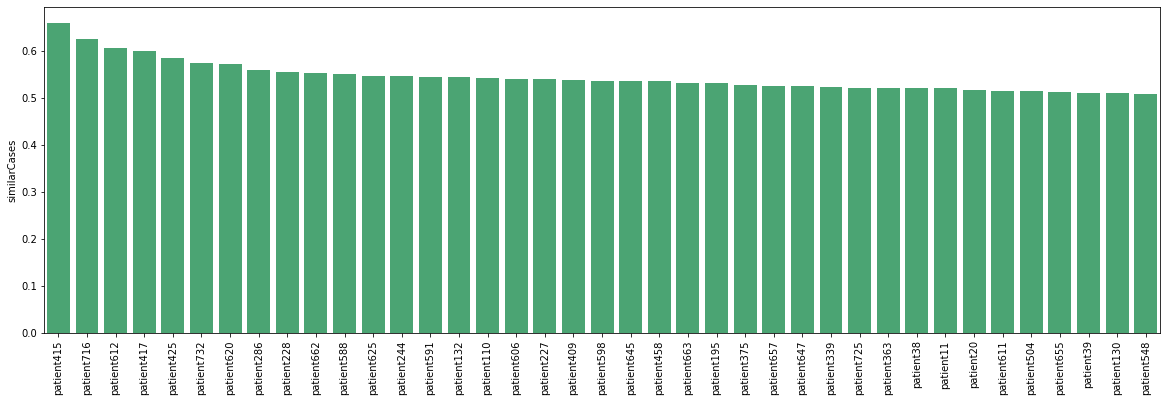

In [18]:
# Plot most similar cases - this requires result_caseIDs from the previous cell (called retrieve_k_sim_byID(..))
plt.rcParams["figure.figsize"] = (20, 6)
plot_retrieve_k_sim_byID(result_caseIDs[1:])

In [19]:
# Find most similar cases and get the full case content for them
result_fullCases = retrieve_k_sim_byID_content(concept, casebase, simFct, 'patient370', '70')
result_fullCases.head()

,age,blood_pressure,bmi,caseID,diabetes_pedigree_function,glucose,id,insulin,outcome,pregnancies,similarity,skin_thickness
0,25,82,38.4,patient370,2.137,173,371,465,1,3,1,48
1,22,84,35.7,patient415,0.258,173,416,474,1,3,0.659804,33
2,31,78,33.8,patient716,0.97,173,717,185,1,3,0.62466,39
3,40,88,38.2,patient612,0.787,168,613,321,1,7,0.605768,42
4,37,82,38.5,patient417,0.554,144,418,0,1,4,0.600109,32


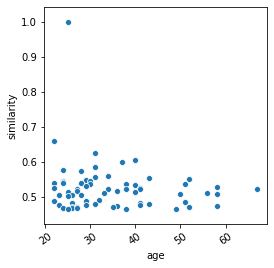

In [20]:
# Create a scatter plot showing the similarity vs. a specified attribute
plt.rcParams["figure.figsize"] = (4, 4)
plot_retrieved_scatter(result_fullCases, attr)

In [21]:
case_rep = get_attributes(get_concepts()[0][0])
case_rep.name.values

array(['age', 'blood_pressure', 'bmi', 'diabetes_pedigree_function',
       'glucose', 'id', 'insulin', 'outcome', 'pregnancies',
       'skin_thickness'], dtype=object)

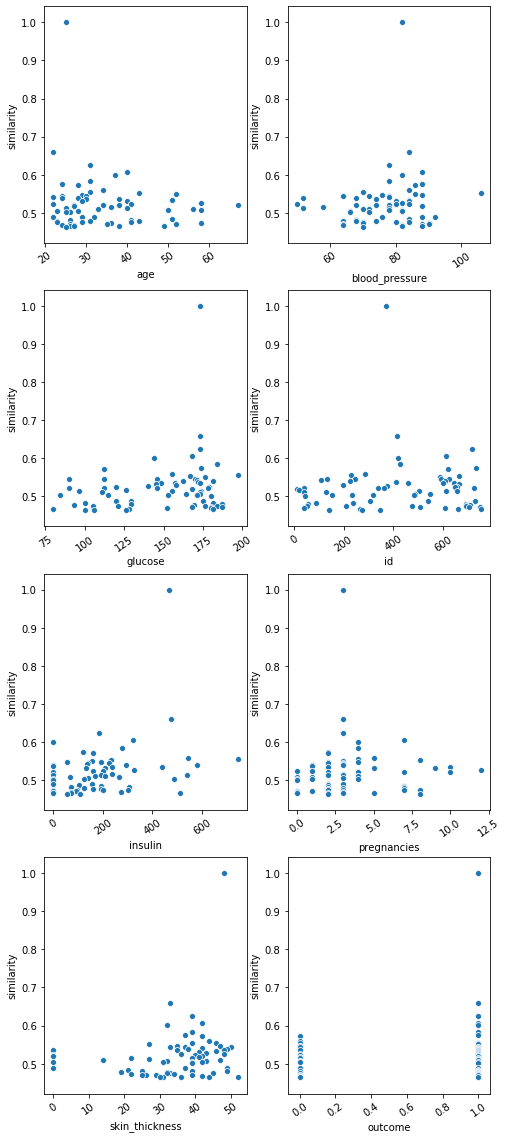

In [140]:
fig = plt.figure(figsize=(8,20))

plt.subplot(4, 2, 1)
plot_retrieved_scatter(result_fullCases, case_rep.name.values[0])

plt.subplot(4, 2, 2)
plot_retrieved_scatter(result_fullCases, case_rep.name.values[1])

plt.subplot(4, 2, 3)
plot_retrieved_scatter(result_fullCases, case_rep.name.values[4])

plt.subplot(4, 2, 4)
plot_retrieved_scatter(result_fullCases, case_rep.name.values[5])

plt.subplot(4, 2, 5)
plot_retrieved_scatter(result_fullCases, case_rep.name.values[6])

plt.subplot(4, 2, 6)
plot_retrieved_scatter(result_fullCases, case_rep.name.values[8])

plt.subplot(4, 2, 7)
plot_retrieved_scatter(result_fullCases, case_rep.name.values[9])

plt.subplot(4, 2, 8)
plot_retrieved_scatter(result_fullCases, case_rep.name.values[7])

plt.show()

# Evaluation
- Function to create Self-Similarity Matrix (ssm) where each case from the case base is queried and then put in a matrix
- Function to compare a list of cases 

In [23]:
def create_ssm(concept, casebase, initital_caseID):
    # set the initial ID to get an order of the if not specified (initital_caseID = -1) by getting all IDs and picking the first
    if initital_caseID == -1:
        all_caseIDs = pd.Series.tolist(get_instances(concept,casebase)['caseID'])  # get a list with all ids
        initital_caseID = all_caseIDs[0] 

    k = '-1'   # number of retrieved cases
    # getting the first column using the inital ID, creating a dataframe and using the similarity order for all next retrievals 
    ssm  = retrieve_k_sim_byID(concept, casebase, initital_caseID, k) 
    ssm_ids = ssm.index[1:] # setting the order for the columns
    ssm = ssm.rename(columns={'similarCases': initital_caseID})

    # running through all cases and adding them to the dataframe
    for caseID in ssm_ids:
        curr_ret = retrieve_k_sim_byID(concept, casebase, caseID, k)
        curr_ret = curr_ret.rename(columns={'similarCases': caseID})
        ssm = pd.concat([ssm, curr_ret], axis=1, join='inner')

    return ssm

def compare_cases(query_case, caseList):
    compared = retrieve_k_sim_byID_content(concept, casebase, simFct, query_case, '-1')
    query = compared[compared['caseID'].isin([query_case])]
    query = query.T
    query = query.rename(columns={query.columns[0]: 'query'})
    compared = compared[compared['caseID'].isin(caseList)]
    compared = compared.sort_values(by='similarity', ascending=False)
    compared = compared.T
    compared = pd.concat([query, compared], axis=1, join='inner')
    return compared

# Visualization
- Heatmap for the results

In [24]:
def plot_heatmap(data , k, annot=True):
    ax = sns.heatmap(data.iloc[:k, :k], annot=annot, cmap="YlGnBu")
    plt.ylim(k, -0.5)
    plt.yticks(rotation=0) 

# Examples for Creating an SSM and plotting it
Some examples how the heatmap and similarity matrix can be used.

In [25]:
ssm = create_ssm(concept, casebase, -1) 

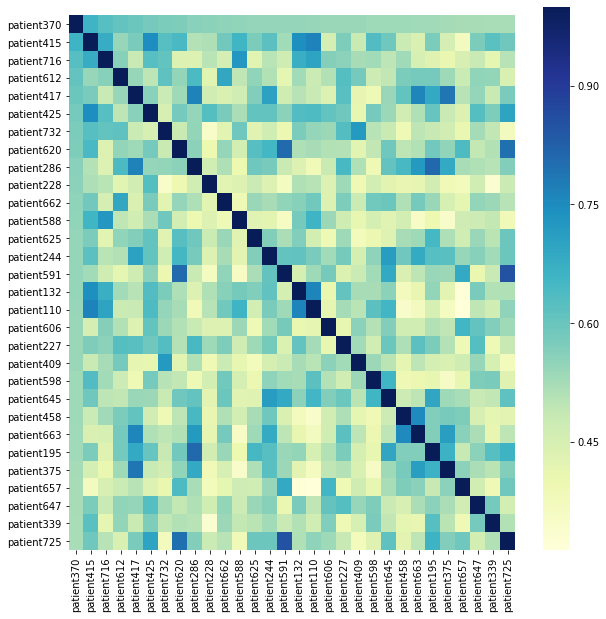

In [142]:
plt.rcParams["figure.figsize"] = (10, 10)
plot_heatmap(ssm, 30, False)

In [27]:
ssm.index

Index(['patient370', 'patient415', 'patient716', 'patient612', 'patient417',
       'patient425', 'patient732', 'patient620', 'patient286', 'patient228',
       ...
       'patient537', 'patient697', 'patient601', 'patient706', 'patient522',
       'patient106', 'patient90', 'patient589', 'patient49', 'patient426'],
      dtype='object', length=768)

In [46]:
#define a list of cases    
caseList = ['patient415', 'patient716', 'patient612', 'patient417']
# compare them with a query
comparison = compare_cases('patient370', caseList)
comparison

,query,229,571,591,244
age,25,22,31,40,37
blood_pressure,82,84,78,88,82
bmi,38.4,35.7,33.8,38.2,38.5
caseID,patient370,patient415,patient716,patient612,patient417
diabetes_pedigree_function,2.137,0.258,0.97,0.787,0.554
glucose,173,173,173,168,144
id,371,416,717,613,418
insulin,465,474,185,321,0
outcome,1,1,1,1,1
pregnancies,3,3,3,7,4


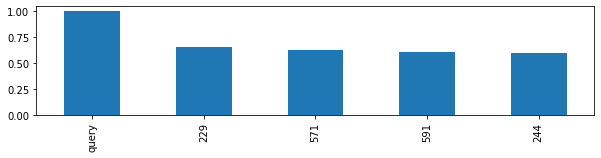

In [47]:
plt.rcParams["figure.figsize"] = (10, 2)
comparison.T.similarity.plot(kind='bar')

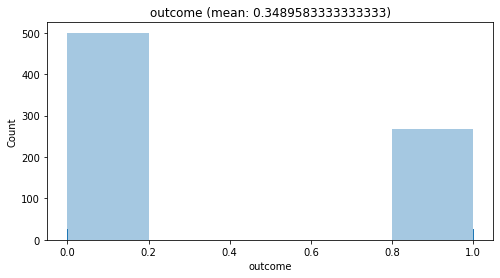

In [48]:
plt.rcParams["figure.figsize"] = (8, 4)
plot_numeric(get_instances(concept, casebase), 'outcome')

In [49]:
# compareTwoInstances?amalgamation%20function=eq_wt_all&case_A_ID=patient402&case_B_ID=patient272

def compareTwoInstances(concept, casebase, amalFct, case_A_ID, case_B_ID):
    raw = pd.DataFrame(requests.get(url + 'concepts/' + concept + '/casebases/' + casebase + '/DetailedCaseComparison?amalgamation%20function='+amalFct+'&case_A_ID=' + case_A_ID + '&case_B_ID=' + case_B_ID ).json()) 
    result = raw.melt().dropna()
    return result

def compareTwoInstancesLocalSim(concept, casebase, amalFct, case_A_ID, case_B_ID):
    raw = pd.DataFrame(requests.get(url + 'concepts/' + concept + '/casebases/' + casebase + '/LocalSimComparison?amalgamation%20function='+amalFct+'&case_A_ID=' + case_A_ID + '&case_B_ID=' + case_B_ID ).json()) 
    result = raw.melt().dropna()
    return result

def getGlobalWeights(concept, casebase, amalFct):
    raw = pd.DataFrame(requests.get(url + 'concepts/' + concept + '/casebases/' + casebase + '/GlobalWeights?amalgamation%20function='+amalFct ).json()) 
    result = raw.melt().dropna()
    return result



In [50]:
def case_comparison_df(concept, casebase, simFct, case_A_ID, case_B_ID):
    global_sim = compareTwoInstances(concept, casebase, simFct, case_A_ID, case_B_ID)
    global_sim = global_sim.rename(columns={'value': 'global_sim'})
    
    local_sim = compareTwoInstancesLocalSim(concept, casebase, simFct, case_A_ID, case_B_ID)
    local_sim = local_sim.rename(columns={'value': 'local_sim'})
    
    weights = getGlobalWeights(concept, casebase, simFct)
    weights = weights.rename(columns={'value': 'weights'})
    
    case_comp = pd.merge(global_sim, local_sim, on='variable', how='outer') 
    case_comp = pd.merge(case_comp, weights, on='variable', how='outer') 
    
    case_values = compare_cases('patient409', ['patient370']).reset_index()
    case_values = case_values.rename(columns={'index': 'variable', 0: 'patient370' })
    case_values = case_values[case_values.variable != 'caseID']

    case_comp = pd.merge(case_comp, case_values, on='variable', how='outer') 
    return case_comp


In [51]:
def plot_sim_comparison(concept, casebase, simFct, case1Name, case2Name):
    plot_data = compareTwoInstances(concept, casebase, simFct, case1Name, case2Name)
    plot_data = plot_data.set_index('variable').rename_axis(index=None)
    
    #plt.figure()
    ax = plot_data.plot(kind='barh', figsize=(4,4), color='royalblue', title= 'Attribute Sim (' + case1Name + ', ' + case2Name  +')' )
    ax.legend().set_visible(False)
    plt.show()
    #plt.close()
    
def plot_localSim_comparison(concept, casebase, simFct, case1Name, case2Name):
    plot_data = compareTwoInstancesLocalSim(concept, casebase, simFct, case1Name, case2Name)
    plot_data = plot_data.set_index('variable').rename_axis(index=None)
    
    #plt.figure()
    ax = plot_data.plot(kind='barh', figsize=(4,4), color='mediumseagreen', title= 'Local Sim (' + case1Name + ', ' + case2Name +')' )
    ax.legend().set_visible(False)
    plt.show()
    #plt.close()
    
def plot_globalSim_comparison(concept, casebase, simFct):
    plot_data = getGlobalWeights(concept, casebase, simFct)
    plot_data = plot_data.set_index('variable').rename_axis(index=None)
    
    #plt.figure()
    ax = plot_data.plot(kind='barh', figsize=(4,4), color='crimson', title= 'Global Sim Weights' )
    ax.legend().set_visible(False)
    plt.show()
    #plt.close()



In [52]:
#plot_sim_comparison(concept, casebase, simFct, 'patient409', 'patient370')
#plot_localSim_comparison(concept, casebase, simFct, 'patient409', 'patient370')
#lot_globalSim_comparison(concept, casebase, simFct)


In [53]:

case_comparison = case_comparison_df(concept, casebase, simFct, 'patient370', 'patient415')
case_comparison

,variable,global_sim,local_sim,weights,query,patient370
0,age,4.104124e+00,6.840207e-01,6.0,28,25
1,blood_pressure,2.874010e+00,7.185025e-01,4.0,68,82
2,bmi,3.078682e+00,4.398118e-01,7.0,42.4,38.4
3,diabetes_pedigree_function,6.383204e-07,9.118862e-08,7.0,0.702,2.137
4,glucose,8.000000e+00,1.000000e+00,8.0,172,173
5,id,0.000000e+00,1.000000e+00,0.0,410,371
6,insulin,2.555334e+00,8.517780e-01,3.0,579,465
7,outcome,0.000000e+00,1.000000e+00,0.0,1,1
8,pregnancies,3.000000e+00,1.000000e+00,3.0,1,3
9,skin_thickness,1.266393e+00,3.165983e-01,4.0,49,48


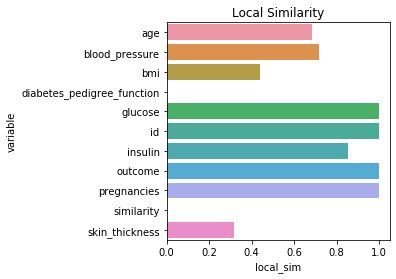

In [54]:
def plot_attr_sim(cc_df, sim, title, yaxis=True):
    cc_plot = cc_df.groupby('variable', as_index=False)[sim].sum()
    ax = sns.barplot(y='variable', x=sim, data=cc_plot)
    ax.axes.get_yaxis().set_visible(yaxis)
    plt.title(title)

plt.rcParams["figure.figsize"] = (4, 4)
#plot_attr_sim(case_comparison, 'global_sim', 'Global Similarity')
plot_attr_sim(case_comparison, 'local_sim', 'Local Similarity')

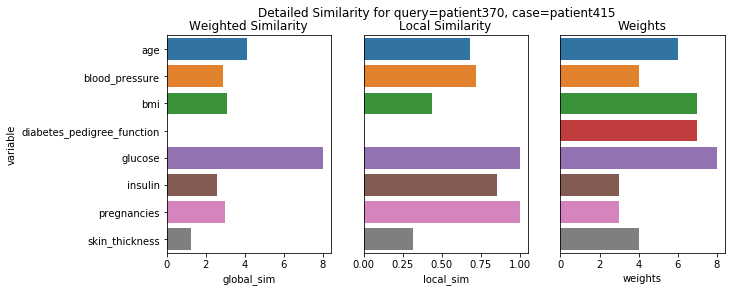

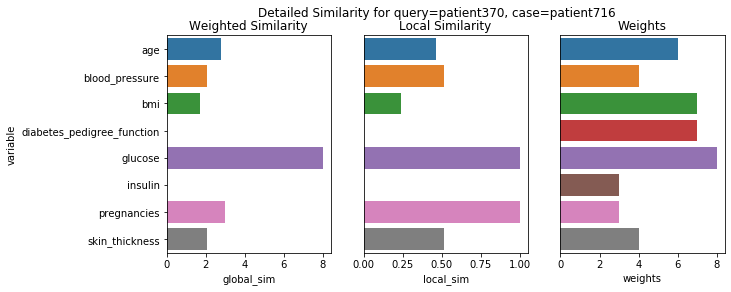

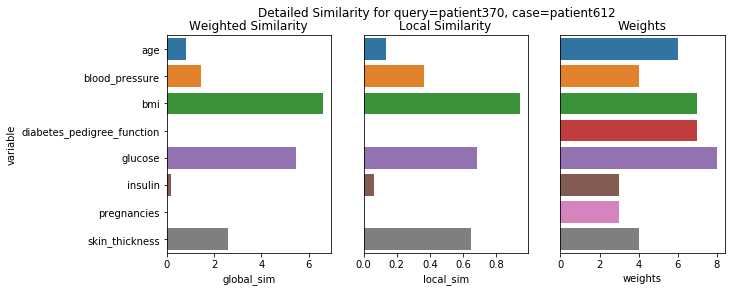

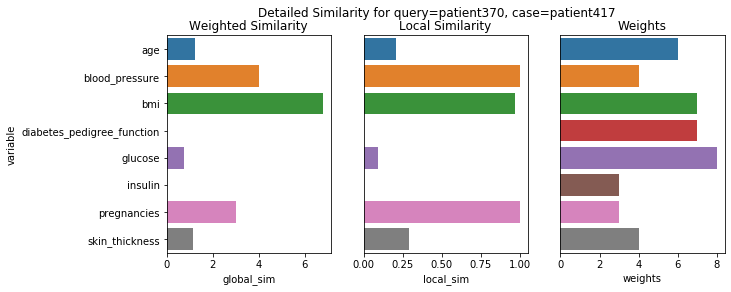

In [60]:
def plot_case_comparison_bars(concept, casebase, simFct, query, case):
    case_comparison = case_comparison_df(concept, casebase, simFct, query, case)
    overall_sim = case_comparison[case_comparison.variable == 'similarity'].values.item(5)
    # include only attributes from the problem description (should be the same as local_sim > 0)
    included_atts = ['age', 'blood_pressure', 'bmi', 'diabetes_pedigree_function', 'glucose', 'insulin', 'pregnancies', 'skin_thickness'] 
    case_comparison = case_comparison[case_comparison['variable'].isin(included_atts)]

    fig = plt.figure(figsize=(10,4))
    #fig.suptitle('Detailed Simila2ity for query=' + query + ', case=' + case + ', Overall Similarity: ' + str(overall_sim))
    fig.suptitle('Detailed Similarity for query=' + query + ', case=' + case )

    plt.subplot(1, 3, 1)
    plot_attr_sim(case_comparison, 'global_sim', 'Weighted Similarity')

    plt.subplot(1, 3, 2)
    plot_attr_sim(case_comparison, 'local_sim', 'Local Similarity', False)

    plt.subplot(1, 3, 3)
    plot_attr_sim(case_comparison, 'weights', 'Weights', False)

plot_case_comparison_bars(concept, casebase, simFct,'patient370', 'patient415')
plot_case_comparison_bars(concept, casebase, simFct,'patient370', 'patient716')
plot_case_comparison_bars(concept, casebase, simFct,'patient370', 'patient612')
plot_case_comparison_bars(concept, casebase, simFct,'patient370', 'patient417')

In [62]:
def plot_case_comparison_compressed(concept, casebase, simFct, query, case):
    case_comparison = case_comparison_df(concept, casebase, simFct, query, case)
    
    included_atts = ['age', 'blood_pressure', 'bmi', 'diabetes_pedigree_function', 'glucose', 'insulin', 'pregnancies', 'skin_thickness'] 
    case_comparison = case_comparison[case_comparison['variable'].isin(included_atts)]

    return case_comparison

test = plot_case_comparison_compressed(concept, casebase, simFct,'patient370', 'patient415')

In [76]:
sims = ssm[:1].T
sims.head()

,patient370
patient370,1.000000
patient415,0.659804
patient716,0.624660
patient612,0.605768
patient417,0.600109


In [79]:
outcome = get_instances(concept, casebase)
outcome = outcome[['caseID', 'outcome']]
outcome = outcome.set_index('caseID').rename_axis(index=None)
outcome.head()

,outcome
patient370,1
patient491,0
patient490,0
patient132,1
patient253,0


In [107]:
results = pd.concat([sims, outcome], axis=1, sort=False)
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, patient370 to patient426
Data columns (total 2 columns):
patient370    768 non-null float64
outcome       768 non-null int64
dtypes: float64(1), int64(1)
memory usage: 18.0+ KB


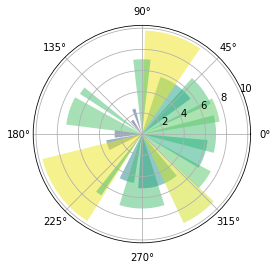

In [87]:
import numpy as np
import matplotlib.pyplot as plt


# Fixing random state for reproducibility
np.random.seed(19680801)

# Compute pie slices
N = 20
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = 10 * np.random.rand(N)
width = np.pi / 4 * np.random.rand(N)
colors = plt.cm.viridis(radii / 10.)

ax = plt.subplot(111, projection='polar')
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.5)

plt.show()

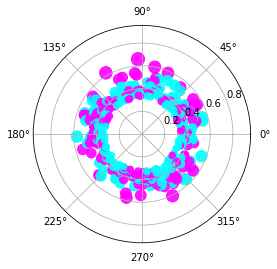

In [134]:
# Fixing random state for reproducibility
#np.random.seed(19680801)

# Compute areas and colors
N = 400
r = results[1:401].patient370
theta = 2 * np.pi * np.random.rand(N)
area = N * r**2
colors = results[1:401].outcome.values

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(theta, r, c=colors, s=area, cmap='cool', alpha=0.9)

In [110]:
r.size

400

In [ ]:
r